## ПРОЕКТ


Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import plotly.express as px
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [370]:
import warnings
warnings.filterwarnings('ignore')

In [371]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 10})  # размер шрифта на графиках

In [372]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df



def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(12,5))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

## Загрузка данных

In [373]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

data = pd.read_csv(TRAIN_DATASET_PATH, delimiter = ',')
test_data = pd.read_csv(TEST_DATASET_PATH, delimiter = ',')


In [374]:
# Описание датасета
# ------------------------------------
# Id - идентификационный номер квартиры
# DistrictId - идентификационный номер района
# Rooms - количество комнат
# Square - площадь
# LifeSquare - жилая площадь
# KitchenSquare - площадь кухни
# Floor - этаж
# HouseFloor - количество этажей в доме
# HouseYear - год постройки дома
# Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
# Social_1, Social_2, Social_3 - социальные показатели местности
# Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
# Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
# Price - цена квартиры

In [375]:
print(f'Размер TRAIN массива данных: {data.shape}')
print(f'Размер TEST массива данных: {test_data.shape}')


Размер TRAIN массива данных: (10000, 20)
Размер TEST массива данных: (5000, 19)


## EDA

In [376]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [377]:
data.sample(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7950,14111,30,2.0,51.352511,NaN,1.0,16,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,146183.961003
9265,7230,23,1.0,43.344592,43.695931,0.0,5,25.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,123074.074975
3984,1523,53,2.0,56.533852,NaN,1.0,18,17.0,2016,0.049637,B,B,34,7759,0,229.0,1,3,B,326449.627289
8841,15659,57,1.0,41.545868,22.652904,8.0,6,12.0,2007,0.133215,B,B,49,11395,3,1406.0,3,4,A,161042.904518
8762,13879,143,1.0,40.283122,20.280208,8.0,13,16.0,1981,0.049863,B,B,18,3746,9,75.0,3,1,B,238591.815148
9381,13136,80,2.0,48.169987,32.512089,6.0,14,12.0,1976,0.007720,B,B,38,4788,2,NaN,0,4,B,233897.213500
4829,4264,40,1.0,38.518469,23.034347,8.0,3,17.0,1996,0.210473,B,B,11,2398,2,1994.0,3,0,B,204670.096676
7190,4578,95,2.0,49.396357,29.672499,7.0,6,8.0,1963,0.000699,B,B,14,3369,24,4129.0,0,3,B,334440.520385
5000,13002,1,1.0,42.645626,NaN,1.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,149411.120343
6119,544,21,2.0,45.041687,29.429017,5.0,5,9.0,1976,0.194489,B,B,47,8004,3,125.0,3,5,B,198707.170554


In [378]:
data.describe().T
# list(data.columns)

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


In [379]:
# Проверка на повторяющиеся данные
dup = data[data.duplicated()]
dup.shape[0]

0

In [380]:
#check for NaN values
pd.isnull(data).sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Распределение целевой переменной

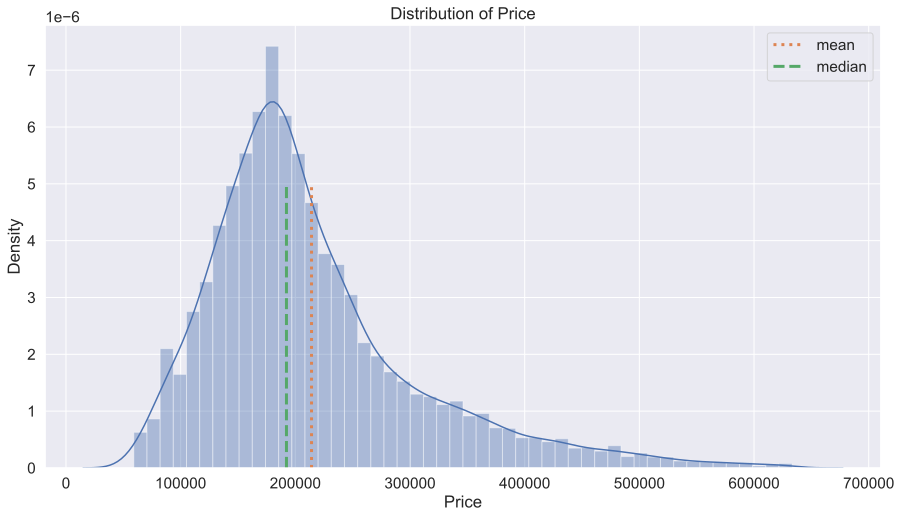

In [381]:
target_mean = round(data['Price'].mean(), 2)
target_median = data['Price'].median()
plt.figure(figsize = (15, 8))

sns.distplot(data['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=3)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=3)


plt.title('Distribution of Price')
plt.legend()
plt.show()

array([[<AxesSubplot: title={'center': 'Rooms'}>,
        <AxesSubplot: title={'center': 'Square'}>,
        <AxesSubplot: title={'center': 'LifeSquare'}>,
        <AxesSubplot: title={'center': 'KitchenSquare'}>],
       [<AxesSubplot: title={'center': 'Floor'}>,
        <AxesSubplot: title={'center': 'HouseFloor'}>,
        <AxesSubplot: title={'center': 'HouseYear'}>,
        <AxesSubplot: title={'center': 'Ecology_1'}>],
       [<AxesSubplot: title={'center': 'Social_1'}>,
        <AxesSubplot: title={'center': 'Social_2'}>,
        <AxesSubplot: title={'center': 'Social_3'}>,
        <AxesSubplot: title={'center': 'Healthcare_1'}>],
       [<AxesSubplot: title={'center': 'Helthcare_2'}>,
        <AxesSubplot: title={'center': 'Shops_1'}>,
        <AxesSubplot: title={'center': 'Price'}>, <AxesSubplot: >]],
      dtype=object)

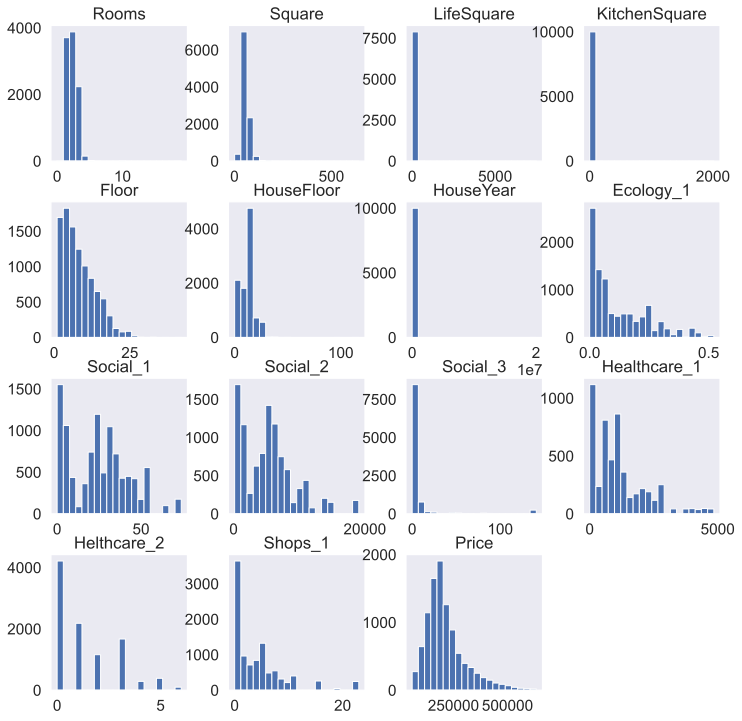

In [382]:
data['Id'] = data['Id'].astype(str)
data['DistrictId'] = data['DistrictId'].astype(str)

data.hist(figsize=(12,12), bins=20, grid=False)

## Визуализация категориальных признаков

In [383]:
data.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [384]:
data.select_dtypes(include='object').value_counts()

Id     DistrictId  Ecology_2  Ecology_3  Shops_2
0      0           B          B          B          1
4927   58          B          B          B          1
4916   94          B          B          B          1
4918   110         B          B          B          1
4920   46          B          B          B          1
                                                   ..
15035  1           B          B          B          1
15036  6           B          B          B          1
15037  11          B          B          B          1
15038  42          B          B          B          1
9999   23          B          B          B          1
Length: 10000, dtype: int64

Text(0.5, 0, 'Ecology_3')

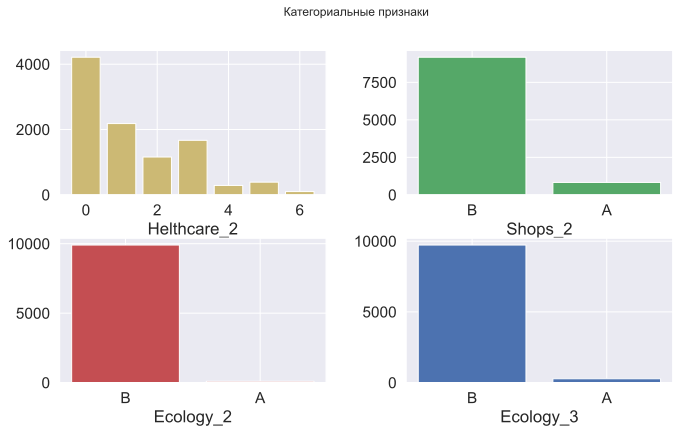

In [385]:
# Визуализация категориальных признаков

fig, axs = plt.subplots(2,2, figsize=(11,6))
fig.subplots_adjust(wspace=0.3, hspace = 0.3)
axs[0,0].bar(data['Helthcare_2'].value_counts().index, data['Helthcare_2'].value_counts(), color = 'y')
axs[0,1].bar(data['Shops_2'].value_counts().index, data['Shops_2'].value_counts(), color = 'g')
axs[1,0].bar(data['Ecology_2'].value_counts().index, data['Ecology_2'].value_counts(), color = 'r')
axs[1,1].bar(data['Ecology_3'].value_counts().index, data['Ecology_3'].value_counts())
plt.suptitle('Категориальные признаки')
axs[0,0].set_xlabel("Helthcare_2")
axs[0,1].set_xlabel("Shops_2")
axs[1,0].set_xlabel("Ecology_2")
axs[1,1].set_xlabel("Ecology_3")

## Проверка на некорректные данные

In [386]:
# 1. Square < LifeSquare
# 2. Square < KitchenSquare
# 3. HouseFloor < Floor 
# 4. HouseYear < Date

In [387]:
# 1. Square < LifeSquare
data.loc[data['Square'] < data['LifeSquare'], ['LifeSquare', 'Square']]

,LifeSquare,Square
28,43.967759,42.530043
44,106.340403,104.211396
52,65.224603,61.400054
123,89.803753,85.952306
153,53.491301,51.831473
...,...,...
9884,59.439082,59.015896
9889,53.134243,51.440463
9895,125.806981,123.430072
9902,44.267551,44.098768


In [388]:


# Обновление некорректных данных 
data.loc[data['Square'] < data['LifeSquare'], 'LifeSquare'] = data.loc[data['Square'] < data['LifeSquare'], 'Square'] - data.loc[data['Square'] < data['LifeSquare'], 'KitchenSquare']
not_LifeSquare = data['Square'] - data['LifeSquare']

data['LifeSquare_nan'] = data['LifeSquare'].isna() * 1
        
condition = (data['LifeSquare'].isna()) &\
                      (~data['Square'].isna()) & \
                      (~data['KitchenSquare'].isna())
        
data.loc[condition, 'LifeSquare'] = data.loc[condition, 'Square'] - data.loc[condition, 'KitchenSquare'] - 3

In [389]:
data['Square'].sort_values(ascending = False)

6977    641.065193
4262    604.705972
4690    409.425181
1982    275.645284
1981    212.932361
           ...    
9294      2.954309
1608      2.596351
4853      2.377248
8283      1.988943
6392      1.136859
Name: Square, Length: 10000, dtype: float64

In [390]:
# 2. Square < KitchenSquare
data.loc[(data['Square'] < data['KitchenSquare'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,...,B,2,629,1,NaN,0,0,A,108337.484207,0
5149,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,...,B,21,5731,0,NaN,1,0,B,160488.033165,0
7088,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,...,B,4,915,0,NaN,0,0,B,99079.960518,0
8584,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,...,B,30,5285,0,645.0,6,6,B,105539.556275,0


In [391]:
# Замена некорректных данных на среднюю площадь комнаты (Жилая площадь / количество комнат)

data.loc[(data['Square'] < data['KitchenSquare']),'KitchenSquare'] = data.loc[(data['Square'] < data['KitchenSquare']),'LifeSquare']/data.loc[(data['Square'] < data['KitchenSquare']),'Rooms']


In [392]:
data['LifeSquare'].sort_values(ascending = False)

6977    638.163193
4262    600.705972
4690    399.425181
1982    233.949309
1981    211.231125
           ...    
9895      0.430072
6609      0.370619
3379      0.138409
6392      0.136859
5888     -0.140758
Name: LifeSquare, Length: 10000, dtype: float64

In [393]:
# 3. HouseFloor > Floor
(data['Floor'] > data['HouseFloor']).sum()


1825

In [394]:
data['HouseFloor_outlier'] = 0
data.loc[data['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
data.loc[data['Floor'] > data['HouseFloor'], 'HouseFloor_outlier'] = 1
        
data.loc[data['HouseFloor'] == 0, 'HouseFloor'] = medians['HouseFloor']
data.loc[data['Floor'] > data['HouseFloor'], 'Floor'] = data.loc[data['Floor'] > data['HouseFloor'], 'HouseFloor']

In [395]:
# 4. HouseYear > Date
data['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
5701        2020
2493        2020
1499        2020
          ...   
7611        1916
910         1914
2656        1912
5111        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int64

In [396]:
# замена некорректных значений на 2020
data['HouseYear_outlier'] = 0
data.loc[X['HouseYear'] > 2020, 'HouseYear_outlier'] = 1
data.loc[X['HouseYear'] > 2020, 'HouseYear'] = 2020


## Обработка выбрасов

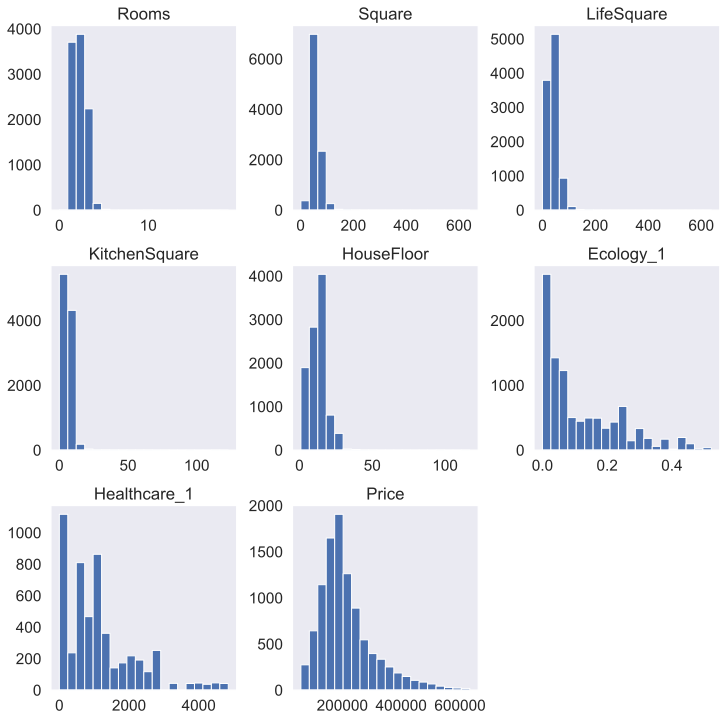

In [397]:
df_num_features = data.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.hist(figsize=(12,12), bins=20, grid=False);

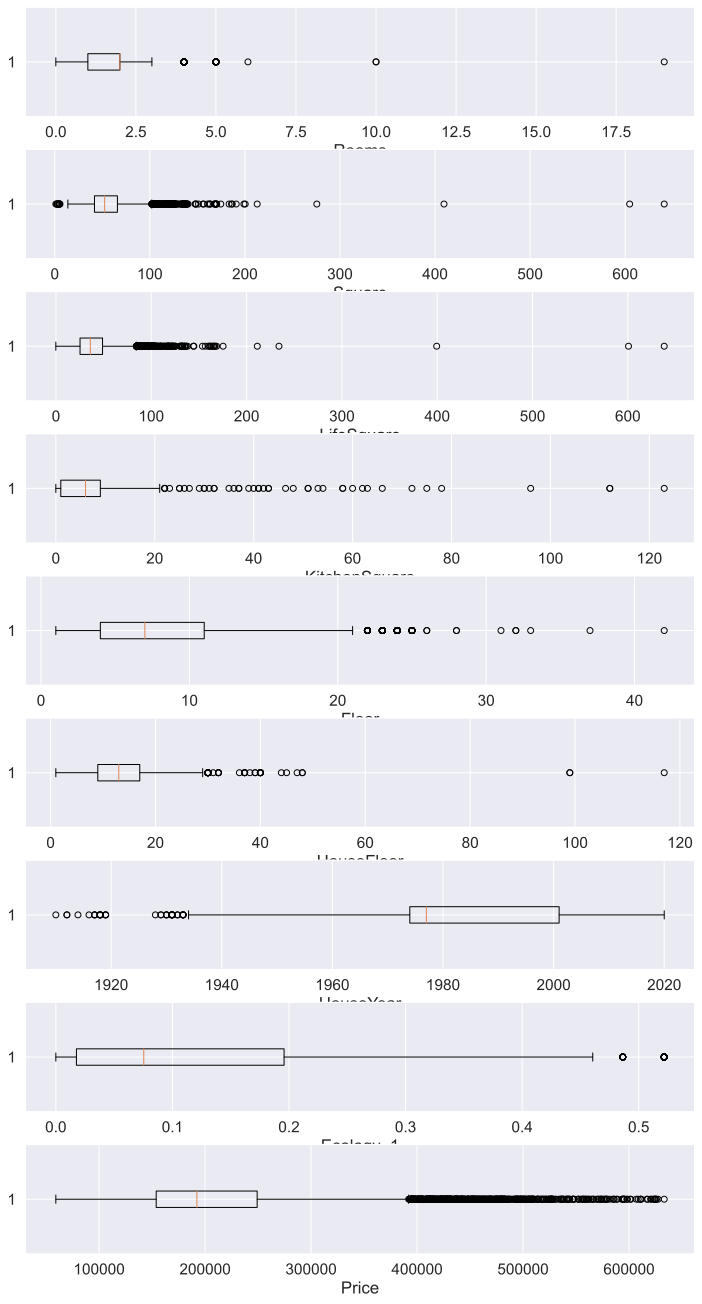

In [398]:
df_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Price']
#  'Ecology_2','Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'HouseFloor_outlier'

fig, ax = plt.subplots(nrows=len(df_features), ncols=1, figsize=(12, 2.5 * len(df_features)))
fig.subplots_adjust(wspace=0.3, hspace = 0.3)
s=0
sns.set(style="darkgrid")
for i in df_features:
    # ax[s].boxplot(data[i], vert=False, whis=1.5)
    ax[s].boxplot(data[i], vert=False)
    ax[s].set_xlabel(i)
    s += 1


In [399]:
# Выбросы по признаку 'Rooms'
data.loc[data['Rooms'] > 6, 'Rooms'].value_counts()

10.0    2
19.0    1
Name: Rooms, dtype: int64

In [400]:
# Замена выбросов по признаку 'Rooms' 
medians = data.median()
data.loc[data['Rooms'] == 0, 'Rooms'] = 1
data.loc[(data['Rooms'] >= 6) & (data['LifeSquare'] < 100 ), 'Rooms'] = medians['Rooms']

In [401]:
# Выбросы по признаку 'Square'
data.loc[data['Square'] > 500, ['LifeSquare', 'Square', 'Price']].value_counts()

LifeSquare  Square      Price        
600.705972  604.705972  187717.242538    1
638.163193  641.065193  133529.681562    1
dtype: int64

In [402]:
data.loc[(data['Square'] < 10) | (data['Square'] > 500), 'Square'] = medians['Square']

In [403]:
# Замена выбросов по признаку 'KitchenSquare' 
not_LifeSquare = data['Square'] - data['LifeSquare']

data.loc[(data['KitchenSquare'] < 6) & (data['KitchenSquare'] < (not_LifeSquare - 6)), 'KitchenSquare'] = 6
data.loc[(data['KitchenSquare'] < 6) & (data['KitchenSquare'] > not_LifeSquare ), 'KitchenSquare'] = medians['KitchenSquare']
data.loc[data['KitchenSquare'] > 100, 'KitchenSquare'] = data['KitchenSquare'].max()

In [404]:
# Выбросы по признаку 'LifeSquare'
data.loc[data['LifeSquare'] > 150, ['LifeSquare', 'Square', 'Price']].value_counts()

LifeSquare  Square      Price        
153.685835  156.636577  502523.573863    1
156.647588  160.647588  217874.997452    1
600.705972  52.513310   187717.242538    1
399.425181  409.425181  90470.430830     1
233.949309  275.645284  455264.882666    1
211.231125  212.932361  302211.260887    1
175.334539  200.334539  528560.506016    1
168.509941  169.509941  200800.673767    1
167.016872  170.016872  531049.721966    1
166.379494  170.379494  194582.912756    1
165.385184  169.385184  190949.293998    1
165.117203  169.117203  211325.577641    1
163.767027  167.767027  211180.794219    1
162.587886  162.587886  207407.352593    1
161.504222  163.495333  207007.956663    1
161.155275  163.286965  228572.520347    1
159.649522  174.649522  232766.187698    1
638.163193  52.513310   133529.681562    1
dtype: int64

In [405]:
data.loc[data['LifeSquare'] > 150, 'LifeSquare'] = 150

In [406]:
# Выбросы по признаку 'Floor'
data.loc[data['Floor'] > 30, ['Floor', 'HouseFloor', 'Price']].value_counts()

Floor  HouseFloor  Price        
31     44.0        117647.461002    1
32     32.0        97480.845791     1
       40.0        393799.531732    1
33     40.0        389554.063540    1
37     38.0        269113.584248    1
42     48.0        411691.504766    1
dtype: int64

In [407]:
data.loc[data['Floor'] > 30, 'Floor'] = 30

In [408]:
# Выбросы по признаку 'Ecology_1'
data.loc[data['Ecology_1'] > 0.45, ['Ecology_1', 'Price']].value_counts()


Ecology_1  Price        
0.458174   84577.918669     1
0.486246   185102.296070    1
           130996.196229    1
           147492.667370    1
           150063.024839    1
                           ..
0.458174   224325.798053    1
           227600.961929    1
           230562.298169    1
           241626.149681    1
0.521867   240912.115999    1
Length: 159, dtype: int64

In [409]:
data.loc[data['Ecology_1'] > 0.45, 'Ecology_1'] = 0.45

## Приведение типов и Оптимизация памяти

In [410]:
# функция оптимицазии памяти
data = reduce_mem_usage(data)

Memory usage of dataframe is 1.75 MB
Memory usage after optimization is: 0.83 MB
Decreased by 52.5%


In [411]:

# преобразование бинарных признаков
data['Ecology_2'] = np.where(data['Ecology_2'] == 'A',0,1)
data['Ecology_3'] = np.where(data['Ecology_3'] == 'A',0,1)
data['Shops_2'] = np.where(data['Shops_2'] == 'A',0,1)


## Обработка пропусков

In [412]:
# Определяем количество пропусков
data.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
LifeSquare_nan           0
HouseFloor_outlier       0
HouseYear_outlier        0
dtype: int64

In [413]:
data.drop('Healthcare_1', axis=1, inplace=True)

In [414]:
data.isna().sum().sum()

0

## Формирование новых признаков

1. размер района (дистрикта)
2. Район большой (True | False)
3. Средняя стоимость объекта в дистрикте в зависимости от количества комнат


In [415]:
# 1. размер района (дистрикта)
# DistrictSize, IsDistrictLarge

district_size = data['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [416]:
data = data.merge(district_size, on='DistrictId', how='left')
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,HouseFloor_outlier,HouseYear_outlier,DistrictSize
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,0,11,1,184966.937500,0,0,0,22
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,10309,1,1,16,1,300009.437500,0,0,0,87
2,4765,53,2.0,44.947952,29.197611,6.0,8,12.0,1968,0.049637,...,7759,0,1,3,1,220925.906250,0,0,0,174
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,5735,3,0,5,1,175616.234375,0,0,0,179
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2,4,1,150226.531250,0,0,0,97


In [417]:
# 2. Район большой (True | False)
# data['DistrictSize'] > 100
data['IsDistrictLarge'] = (data['DistrictSize'] > 100).astype(int)

In [418]:
# 3. Средняя стоимость в дистрикте в зависимости от количества комнат

agg_func_math = {'Price': 'median'}

med_price_by_district = data.groupby(['DistrictId', 'Rooms']).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

MedPriceByDistrict
DistrictId Rooms                    
0          1.0         142799.437500
           2.0         176210.812500
           3.0         300610.359375
           4.0                   NaN
           5.0                   NaN

In [419]:
data = data.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,HouseFloor_outlier,HouseYear_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,1,184966.937500,0,0,0,22,0,207786.132812
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,1,16,1,300009.437500,0,0,0,87,0,300009.437500
2,4765,53,2.0,44.947952,29.197611,6.0,8,12.0,1968,0.049637,...,1,3,1,220925.906250,0,0,0,174,1,263206.218750
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,0,5,1,175616.234375,0,0,0,179,1,166809.671875
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,1,150226.531250,0,0,0,97,0,158539.054688


## Определение линейной зависимости целевой переменной

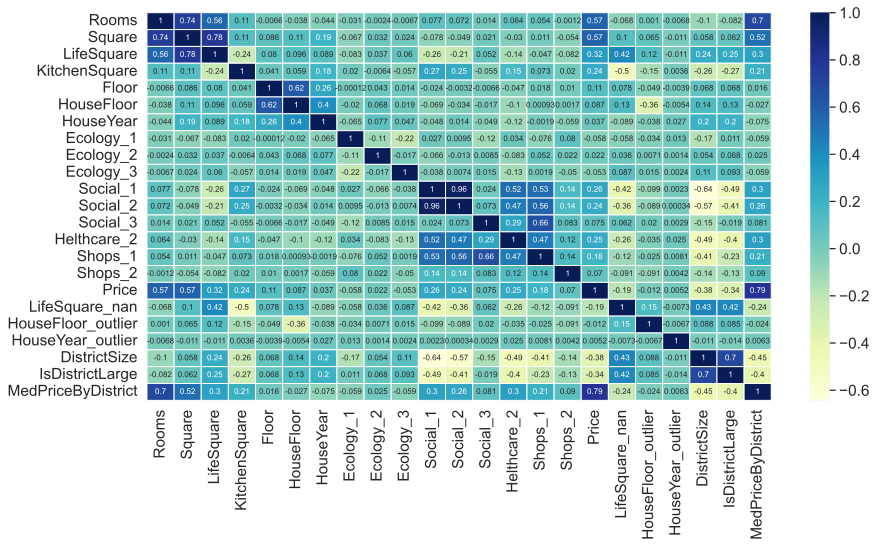

In [420]:
plt.figure(figsize = (14,7))
sns.set(font_scale=1.4)
sns.heatmap(data.corr(), linecolor='white', linewidths=1,  annot=True, annot_kws={"size":8}, cmap="YlGnBu");

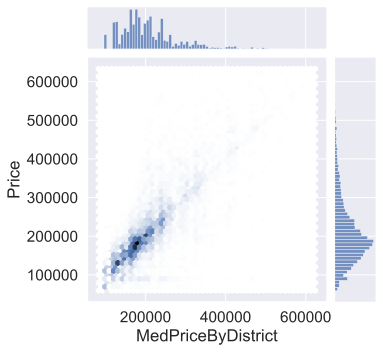

In [421]:
# Максимальная положительная корреляция с признаком MedPriceByDistrict
grid = sns.jointplot(x=data['MedPriceByDistrict'], y=data['Price'], kind='hex')
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)

plt.show()

### Preprocessing

In [422]:
class DataPreprocessing:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # нежилая площадь
        not_LifeSquare = X['Square'] - X['LifeSquare']
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[(X['Rooms'] >= 6) & (X['LifeSquare'] < 100 ), 'Rooms'] = self.medians['Rooms'] 
        
         # Square 
        X.loc[(X['Square'] < 10) | (X['Square'] > 500), 'Square'] = self.medians['Square']
        
        # KitchenSquare
        X.loc[(X['KitchenSquare'] < 6) & (X['KitchenSquare'] < (not_LifeSquare - 6)), 'KitchenSquare'] = 6
        X.loc[(X['KitchenSquare'] < 6) & (X['KitchenSquare'] > not_LifeSquare ), 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] > 100, 'KitchenSquare'] = X['KitchenSquare'].max()
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']

        # HouseYear
        current_year = 2020 #datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [423]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

# Подготовка данных

In [424]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [425]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

In [426]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [427]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33, shuffle=True, random_state=42)

In [428]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [429]:
feature_gen = FeatureGenetator()
feature_gen.fit(X_train, y_train)

X_train = feature_gen.transform(X_train)
X_valid = feature_gen.transform(X_valid)
test_df = feature_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

In [430]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

# Построение модели

In [431]:
gbr = GradientBoostingRegressor(criterion='squared_error',
                                        max_depth=6,
                                        max_features=5,
                                        min_samples_leaf=70,
                                        random_state=42,  
                                        n_estimators=150)

In [432]:
%%time
gbr.fit(X_train, y_train)

CPU times: user 1.33 s, sys: 18.8 ms, total: 1.35 s
Wall time: 1.58 s


GradientBoostingRegressor(criterion='squared_error', max_depth=6,
                          max_features=5, min_samples_leaf=70, n_estimators=150,
                          random_state=42)

Train R2:	0.845
Test R2:	0.714


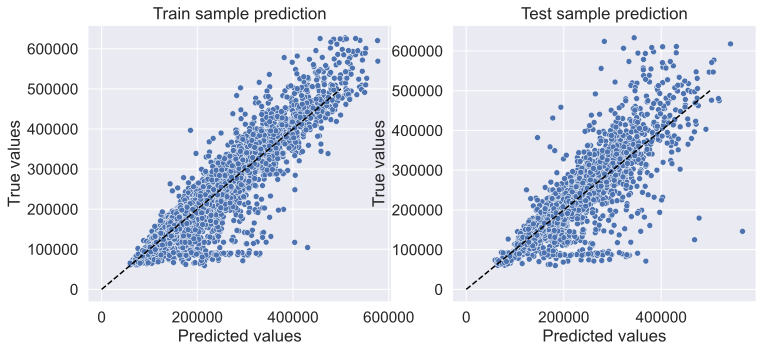

In [433]:
y_train_preds = gbr.predict(X_train)
y_test_preds = gbr.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# Прогноз на тестовом датасете & выгрузка в CSV

In [434]:
y_test_preds = gbr.predict(test_df)
my_preds = pd.DataFrame(data=y_test_preds, columns = ['Price'])
my_preds = my_preds.reset_index(names=['ID'])

my_preds.to_csv('Kluchnikov_predictions.csv', index=False)


my_preds['Price'].describe()

count      5000.000000
mean     214247.816536
std       76524.269651
min       63540.746194
25%      163790.820784
50%      196383.509801
75%      250527.108694
max      565135.879544
Name: Price, dtype: float64